# Tensorflow CNN - Dogs vs. Cats

In [9]:
import os

import numpy as np
import PIL.Image as Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

In [2]:
# Tensorflow Settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Training Settings
TRAIN_DIR = '../data/dogs-vs-cats/train/'
VAL_DIR = '../data/dogs-vs-cats/val/'
CLASS_NAMES = ['cat', 'dog']

# CNN Settings
BATCH_SIZE = 25
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Data
"""
keras.preprocessing method is convienient, but has two downsides:

1. It's slow. See the performance section
2. It lacks fine-grained control.
3. It is not well integrated with the rest of TensorFlow.

Use tf.data.Dataset for a more optimized API
"""

# Define Image Generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = train_generator.flow_from_directory(directory=TRAIN_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_data_gen = val_generator.flow_from_directory(directory=VAL_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
____

In [5]:
# Train

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
if not os.path.exists("../data/dogs-vs-cats/weights/"):
    os.makedirs("../data/dogs-vs-cats/weights/")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "../data/dogs-vs-cats/weights/model.h5",
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    period=1,
)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto'
)

# Fit
history = model.fit_generator(
    train_data_gen,
    epochs=10000,
    validation_data=val_data_gen,
    callbacks = [checkpoint, early]
)

Epoch 1/10000
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
798/800 [============================>.] - ETA: 0s - loss: 0.6844 - acc: 0.6378
Epoch 00001: loss improved from inf to 0.68418, saving model to ../data/dogs-vs-cats/weights/model.h5
800/800 [==============================] - 46s 58ms/step - loss: 0.6842 - acc: 0.6378 - val_loss: 0.5814 - val_acc: 0.6976
Epoch 2/10000
799/800 [============================>.] - ETA: 0s - loss: 0.5124 - acc: 0.7523
Epoch 00002: loss improved from 0.68418 to 0.51255, saving model to ../data/dogs-vs-cats/weights/model.h5
800/800 [==============================] - 44s 55ms/step - loss: 0.5126 - acc: 0.7521 - val_loss: 0.5158 - val_acc: 0.7468
Epoch 3/10000
798/800 [============================>.] - ETA: 0s - loss: 0.3096 - acc: 0.8651
Epoch 00003: loss improved from 0.51255 to 0.30967, saving model to ../data/dogs-vs-cats/weights/model.h5
800/800 [==============================] - 44s 55ms/step - loss:

Train Accuracy:	 99.31% Train Loss:	 0.027149
Val Accuracy:	 71.64% Val Loss:	 1.787321


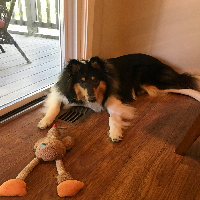

IMG_5777.jpg
[[0.12906578 0.87093425]]
dog


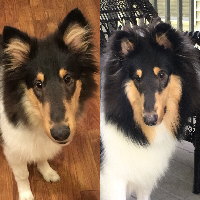

IMG_5936.jpg
[[2.8298933e-05 9.9997175e-01]]
dog


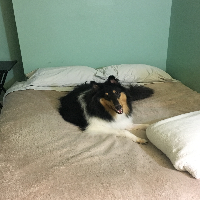

IMG_5889.jpg
[[9.999888e-01 1.123542e-05]]
cat


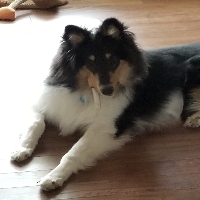

IMG1297181182.jpg
[[9.9987364e-01 1.2636826e-04]]
cat


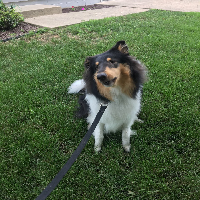

IMG_5868.jpg
[[2.5816638e-09 1.0000000e+00]]
dog


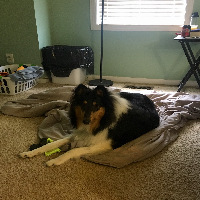

IMG_5881.jpg
[[0.00877115 0.9912288 ]]
dog


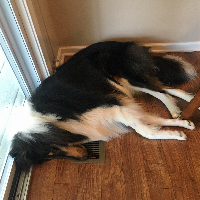

IMG_5817.jpg
[[9.419349e-05 9.999058e-01]]
dog


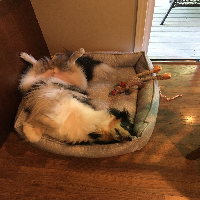

IMG_5770.jpg
[[2.344560e-06 9.999976e-01]]
dog


In [12]:
# Metrics

# Train
acc = history.history['acc'][-1]
loss = history.history['loss'][-1]
print(f'Train Accuracy:\t {acc*100:0.2f}%', f'Train Loss:\t {loss:0.6f}')

# Validate
score = model.evaluate_generator(val_data_gen)
print(f'Val Accuracy:\t {score[1]*100:0.2f}%', f'Val Loss:\t {score[0]:0.6f}')

# Predict Leo Images
from os import listdir
from os.path import isfile, join
leo_path = '../data/dogs-vs-cats/leo/'
leo_files = [f for f in listdir(leo_path) if isfile(join(leo_path, f))]

for file in leo_files:
    img = '../data/dogs-vs-cats/leo/' + file
    img = Image.open(img).resize(IMG_SHAPE)
    display(img)
    img = np.array(img)/255
    
    # Add batch dimension to image and predict
    pred = model.predict(img[np.newaxis,])
    print(file)
    print(pred)
    print(CLASS_NAMES[np.argmax(pred)])